In [1]:
print("hello")

from helm.benchmark.runner import InstanceGenerations
from typing import Any, List
import json

json_path="/Users/lukecadigan/thesis/helm/full_tests/beam2_8B.json"

with open(json_path,'r') as json_file:
    instances_dict=json.load(json_file)

hello


In [2]:
from helm.common.request import (GeneratedOutput)

In [3]:
def json_to_instance_generation(instance_dict:dict) -> InstanceGenerations:
    instance_generation = InstanceGenerations(**instance_dict)
    examples = [ GeneratedOutput(**generated_output_dict) for generated_output_dict in instance_generation.examples]
    instance_generation.examples=examples
    return instance_generation


instance_generations = [json_to_instance_generation(instance_dict)  for instance_dict in instances_dict ]



In [4]:
def truncate_sequence(text, all_stops=["<|end_of_text|>"]):
    for stop in all_stops:
        try:
            text = text[: text.index(stop)]
        except ValueError:
            pass
    return text


ref is     :He advised the parents of a boy whose penis had been severed in a botched circumcision to have the child fully castrated, removing his testicles, as well, and to raise him as a girl.
example is : He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
bleu_score is  1.3355980882200826


In [5]:
from dataclasses import dataclass

from abc import abstractmethod, ABC

from helm.benchmark.metrics.evaluate_reference_metrics import bleu_4

class PostMetric(ABC):
    @property
    @abstractmethod
    def name(self)->str:
        pass
    @abstractmethod
    def calculate_metric(self, instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        pass

class SentenceLenMetric(PostMetric):
    @classmethod
    def name(cls)->str:
        return "completion_length"
    @classmethod    
    def calculate_metric(self,instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        return len(generated_output.text)
    
class CompletionProbMetric(PostMetric):
    @classmethod
    def name(cls)->str:
        return "completion_logprob"
    @classmethod    
    def calculate_metric(self,instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        return generated_output.logprob
    
class InstanceIdMetric(PostMetric):
    @classmethod
    def name(cls)->str:
        return "instanceID"
    @classmethod
    def calculate_metric(self, instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        return instance_generation.instance_id


class BLEU_METRIC(PostMetric):
    @classmethod
    def name(cls)->str:
        return "BLEU"
    @classmethod
    def calculate_metric(self,instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        sys=[]
        reference = instance_generation.reference
        completion=truncate_sequence(generated_output.text).strip()
        print(f"completion is {completion}")
        print(f"reference is  {reference}")
        return bleu_4(completion,reference)


        
base_metrics=[SentenceLenMetric(),CompletionProbMetric(), InstanceIdMetric()]
new_metrics = [BLEU_METRIC()]
metrics=base_metrics+new_metrics

metrics_dicts=[]
counter=0
for instance_generation in instance_generations:
    for generated_output in instance_generation.examples:
        metrics_dict={}
        for metric in metrics:
            metrics_dict[metric.name()] = metric.calculate_metric(instance_generation, generated_output)
        metrics_dicts.append(metrics_dict)                

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


completion is He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
reference is  He advised the parents of a boy whose penis had been severed in a botched circumcision to have the child fully castrated, removing his testicles, as well, and to raise him as a girl.
completion is He advised the parents of a boy whose penis had been severed during a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
reference is  He advised the parents of a boy whose penis had been severed in a botched circumcision to have the child fully castrated, removing his testicles, as well, and to raise him as a girl.
completion is Airbus states that the competing version of the A350 carries 350 people in 18-inch seats in economy class, with nine per row.
reference is  Airbus says the competing version of its A350 will carry 350 people in

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

In [6]:
import pandas as pd
df = pd.DataFrame(metrics_dicts)

In [13]:
print(df["BLEU"].mean())
print(df.keys())

0.15405728774448454
Index(['completion_length', 'completion_logprob', 'instanceID', 'BLEU'], dtype='object')


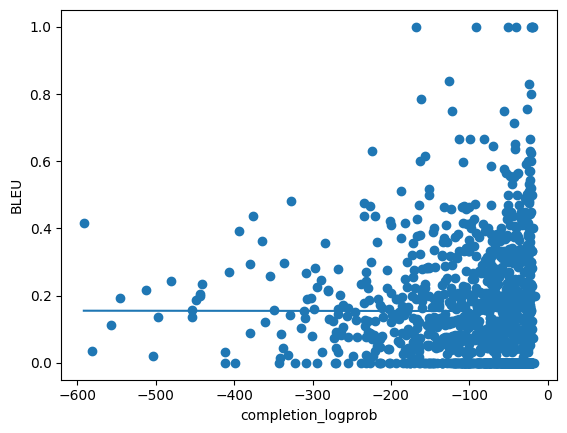

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_keys(xlabel, ylabel):
    x=df[xlabel]
    y=df[ylabel]
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.show()

plot_keys("completion_logprob","BLEU")
